#### Import Libraries 

In [30]:
import pandas as pd
import numpy as np

# Define file names
file_names = ['HR_01.txt', 'HR_02.txt', 'SL_01.txt', 'SL_02.txt', 'SK_01.txt', 'SK_02.txt']

# Function to load and clean data
def load_clean_data(file_name):
    data = pd.read_csv(file_name, delimiter=',', skiprows=4)  # Adjust skiprows if needed
    numeric_data = data.select_dtypes(include=[np.number])
    return numeric_data.to_numpy()

# Load data from all files
eeg_data = [load_clean_data(file) for file in file_names]

# Print shapes of loaded data
for i, data in enumerate(eeg_data):
    print(f"Shape of data from {file_names[i]}: {data.shape}")



Shape of data from HR_01.txt: (30355, 24)
Shape of data from HR_02.txt: (30842, 24)
Shape of data from SL_01.txt: (4839, 24)
Shape of data from SL_02.txt: (30180, 24)
Shape of data from SK_01.txt: (34488, 24)
Shape of data from SK_02.txt: (30640, 24)


In [31]:
from scipy.signal import butter, filtfilt

# Define a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Filter the data for each file
sampling_rate = 256  # Example sampling rate, adjust if needed
lowcut = 0.5  # Hz
highcut = 50  # Hz

filtered_eeg_data = [apply_bandpass_filter(data, lowcut, highcut, sampling_rate) for data in eeg_data]


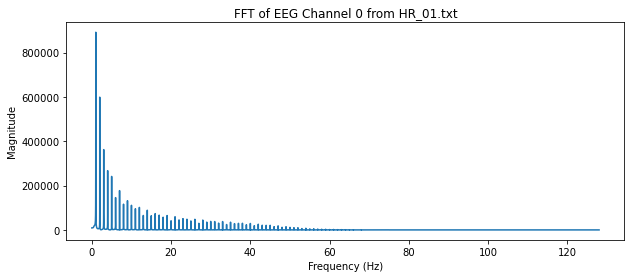

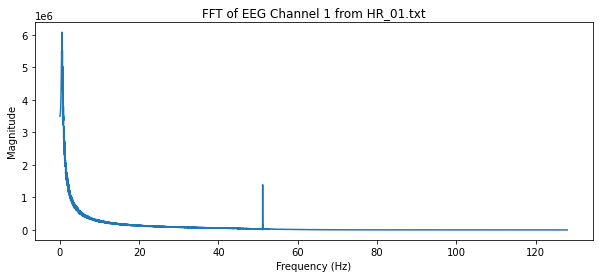

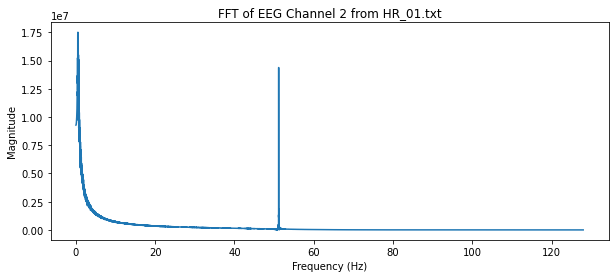

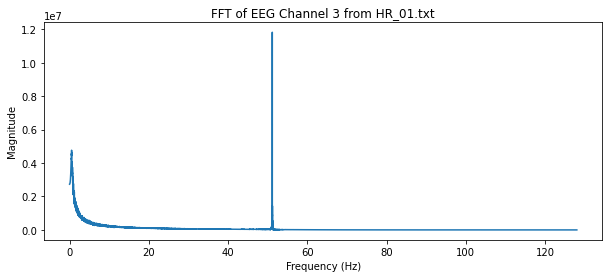

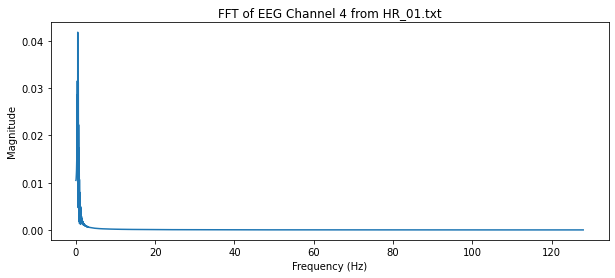

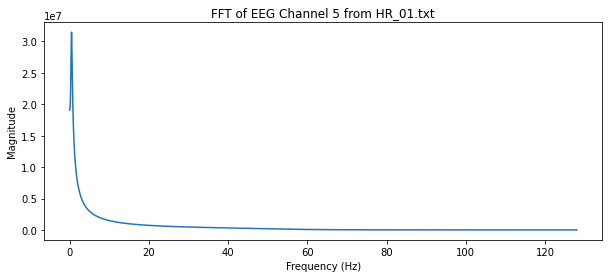

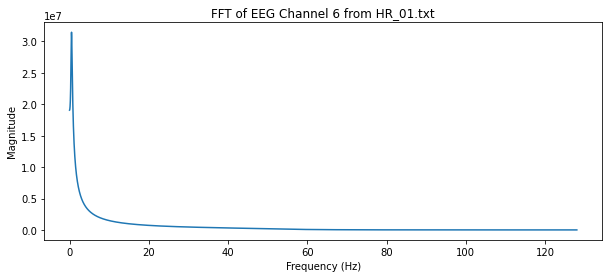

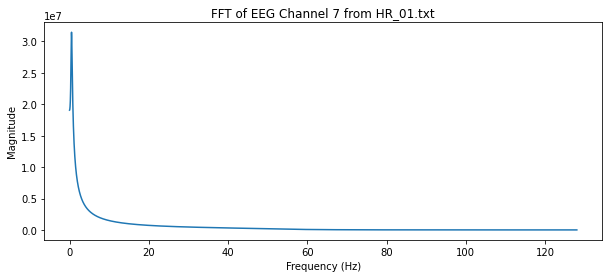

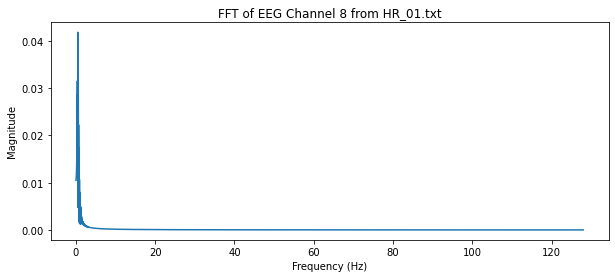

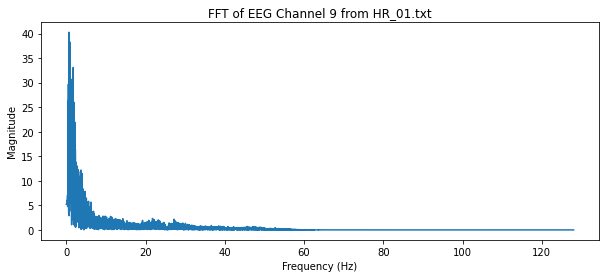

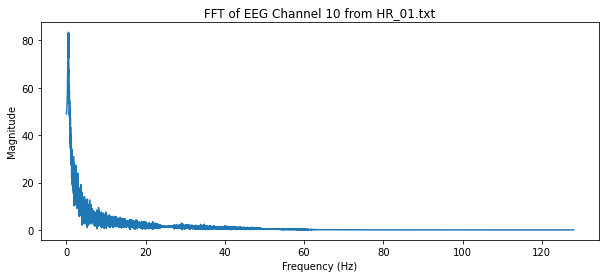

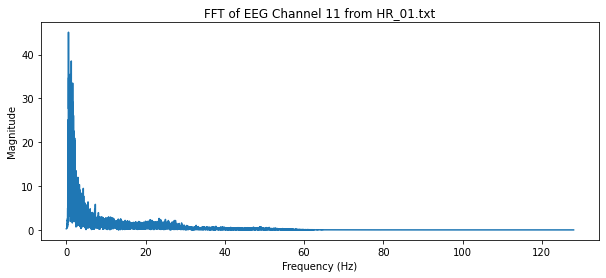

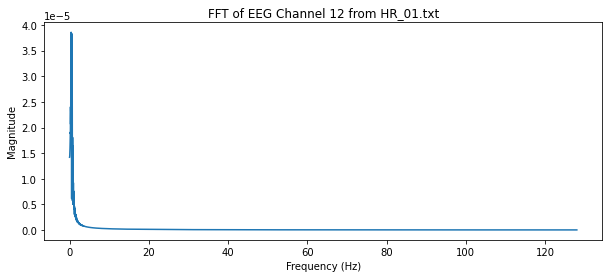

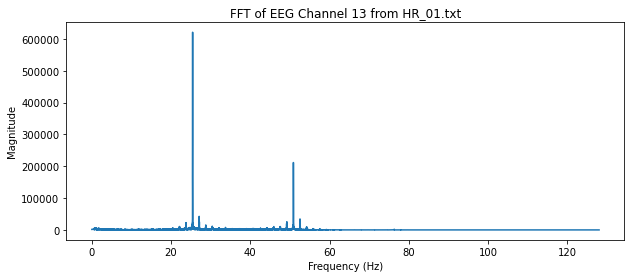

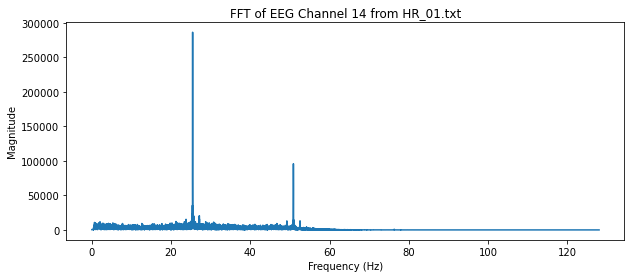

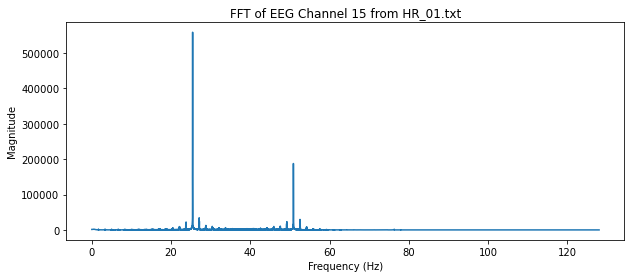

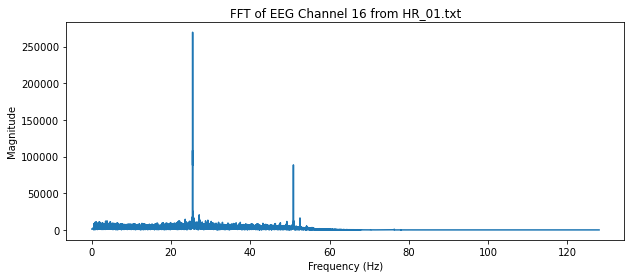

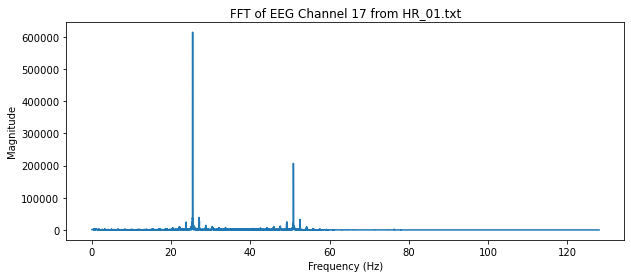

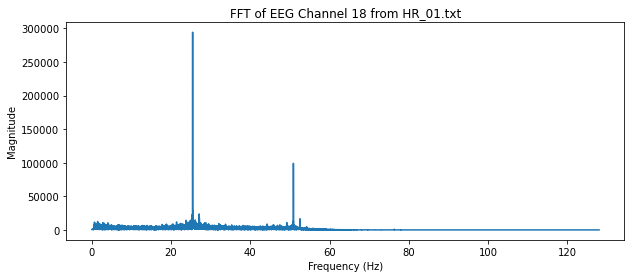

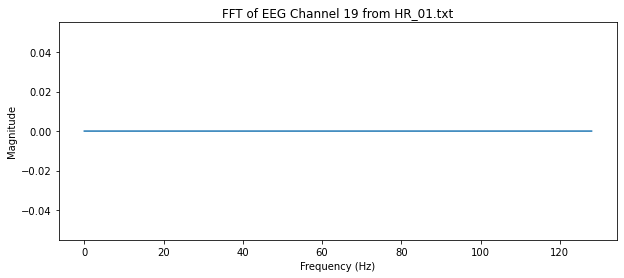

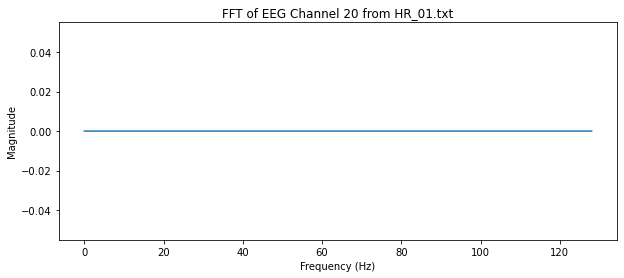

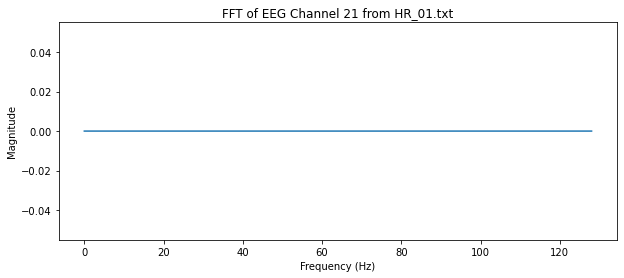

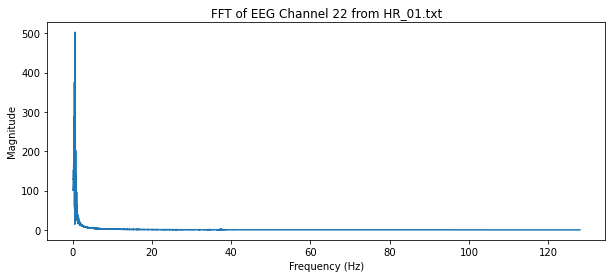

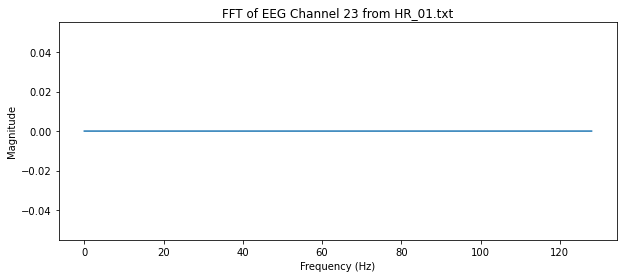

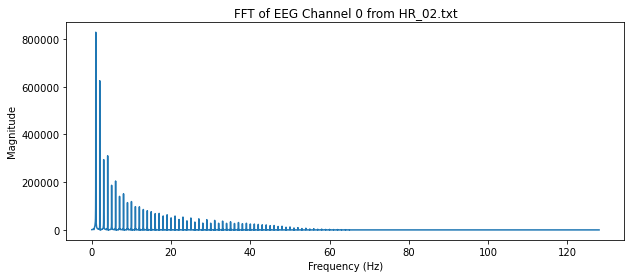

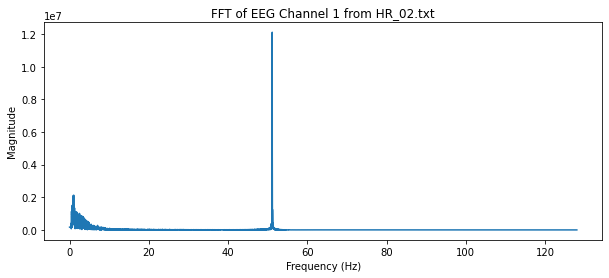

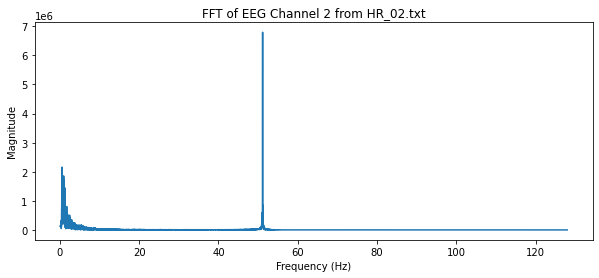

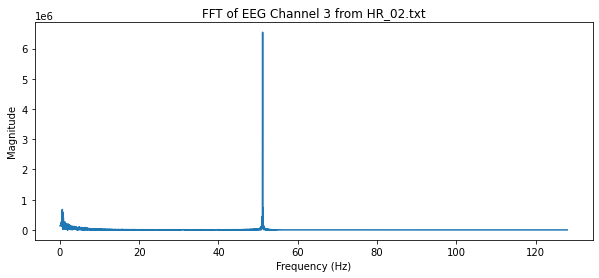

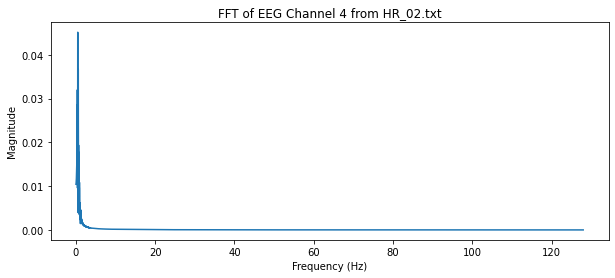

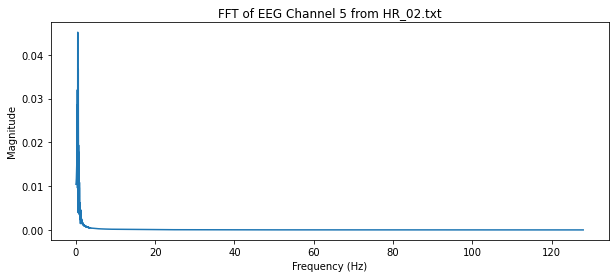

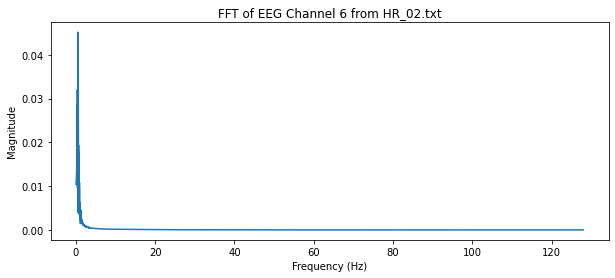

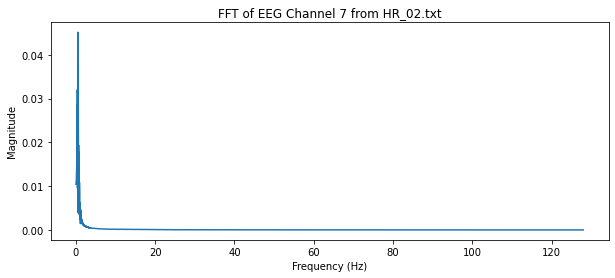

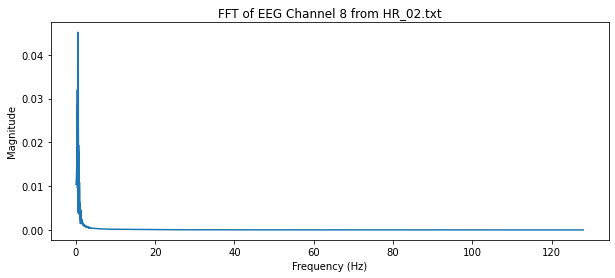

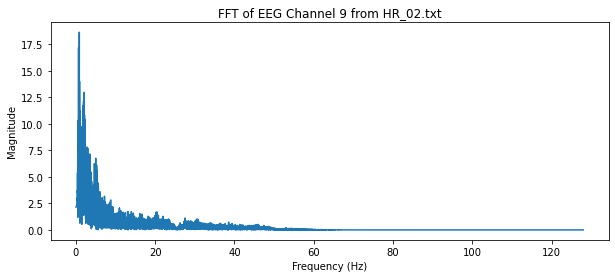

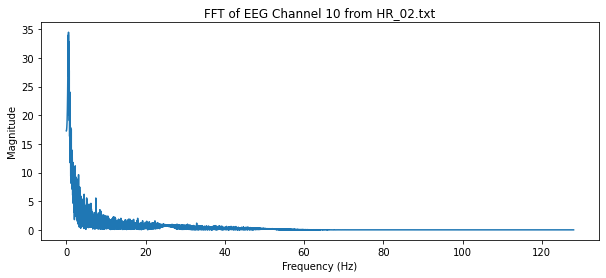

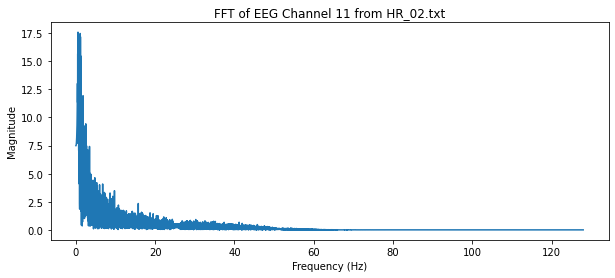

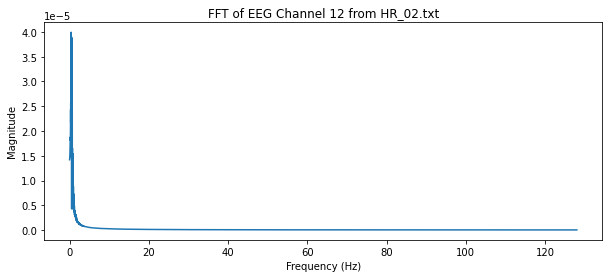

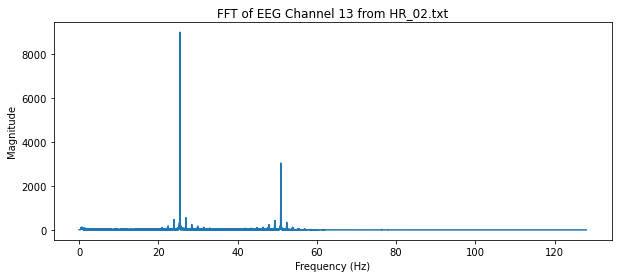

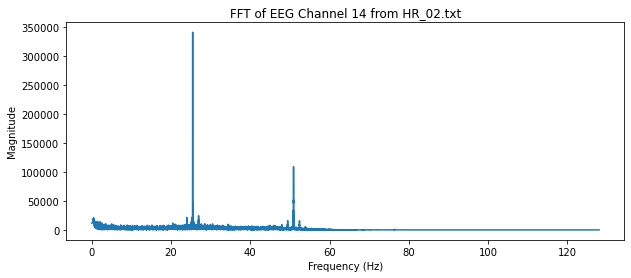

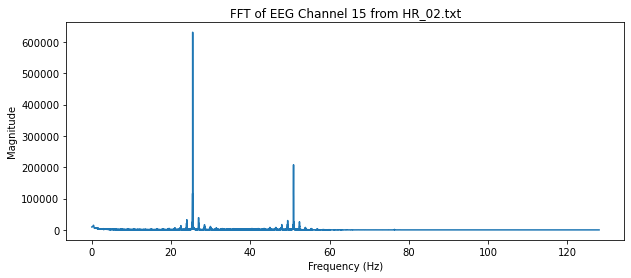

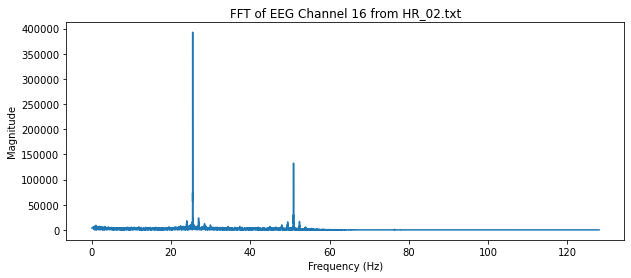

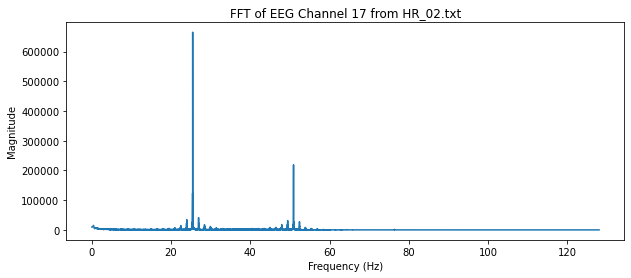

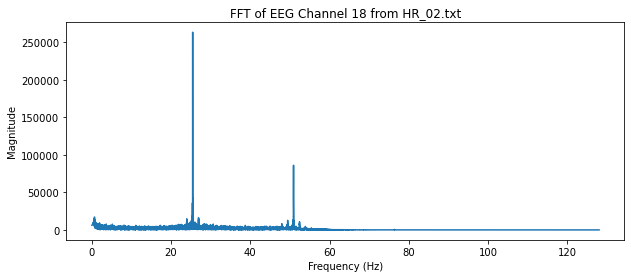

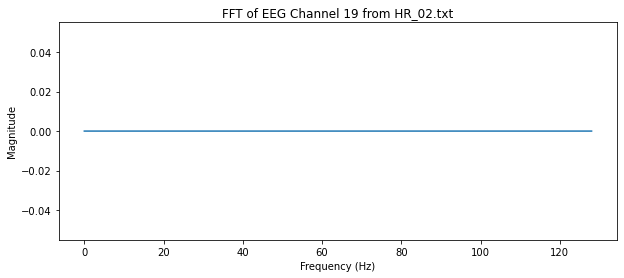

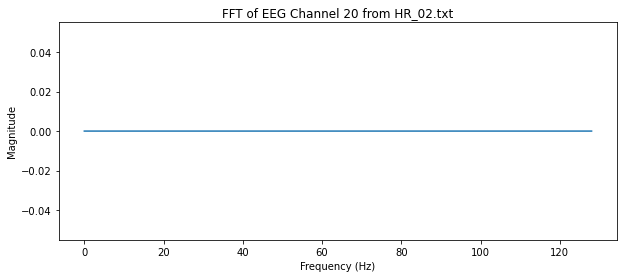

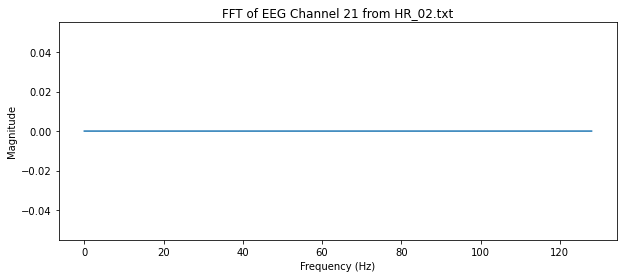

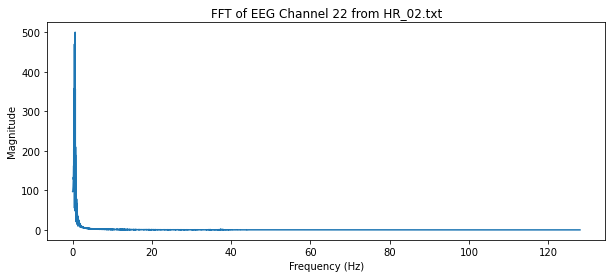

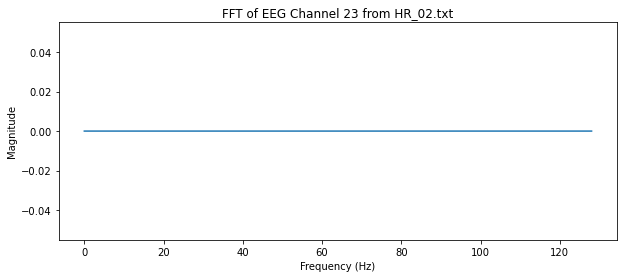

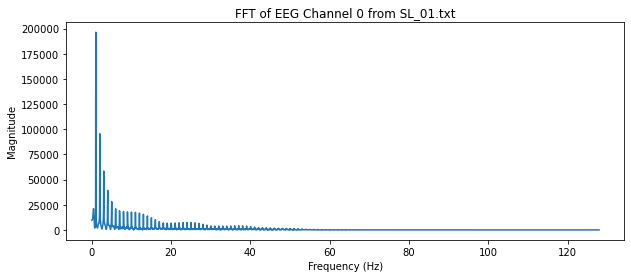

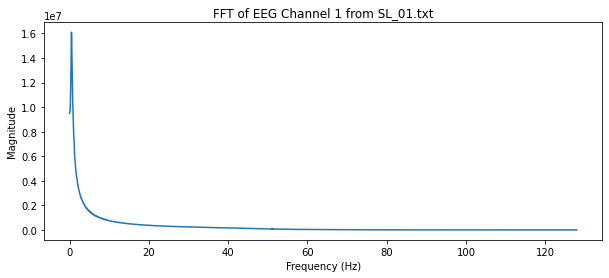

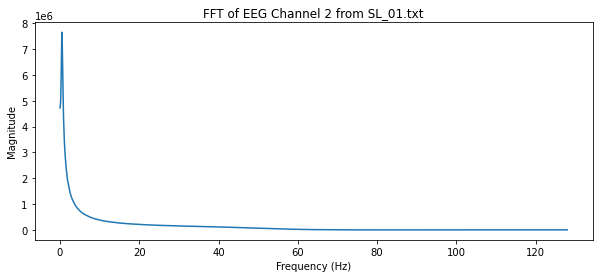

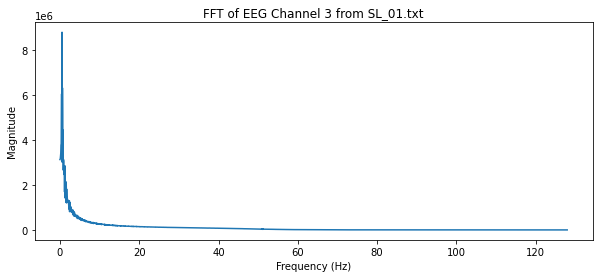

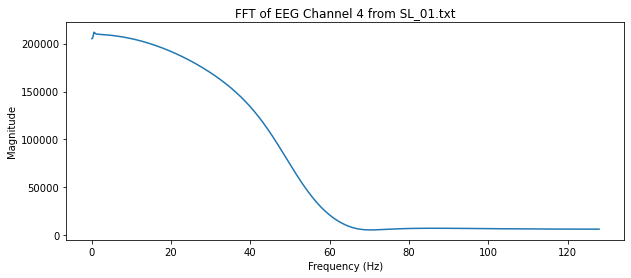

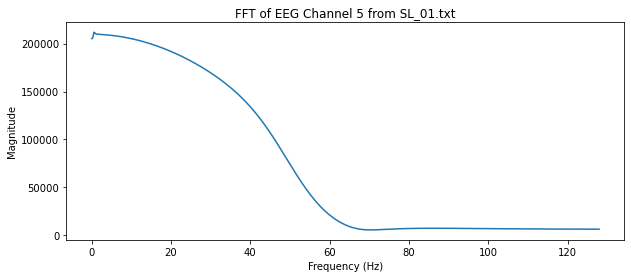

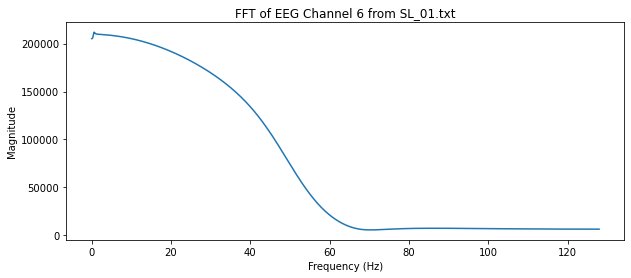

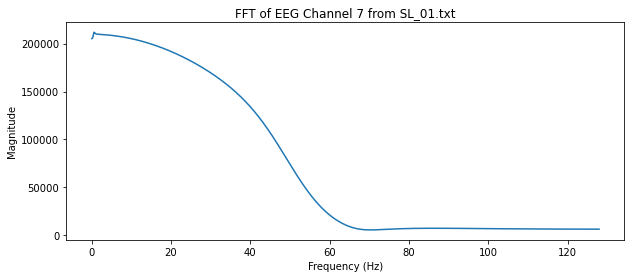

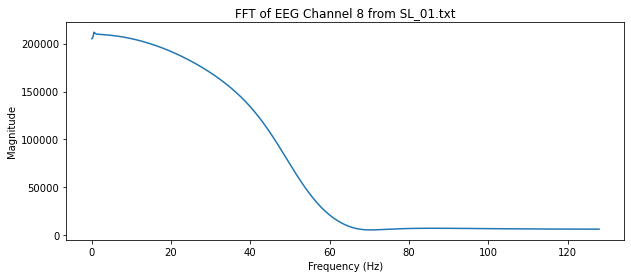

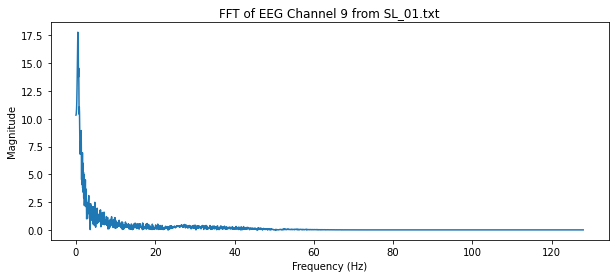

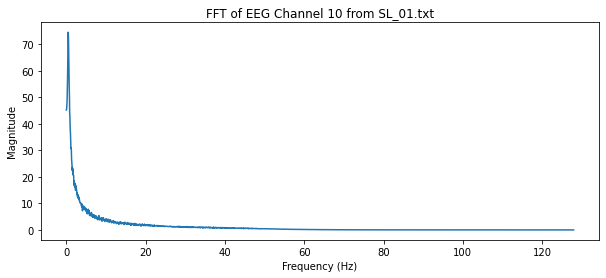

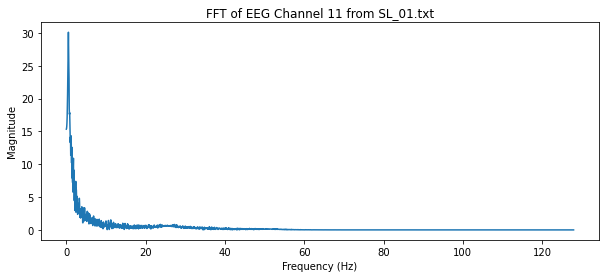

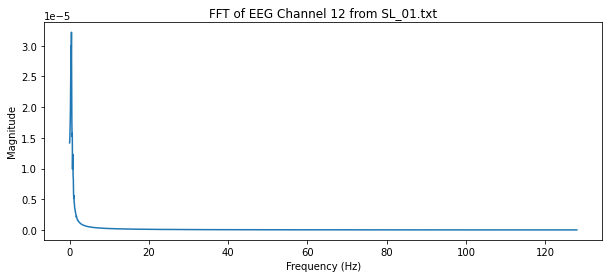

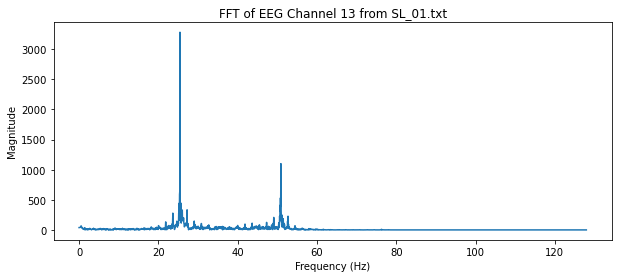

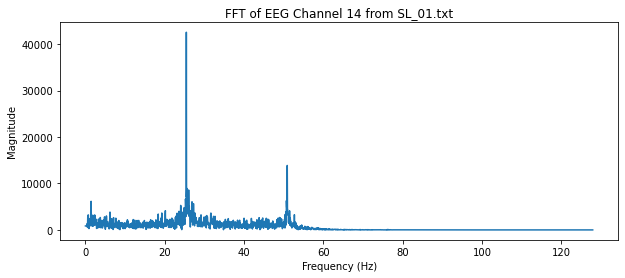

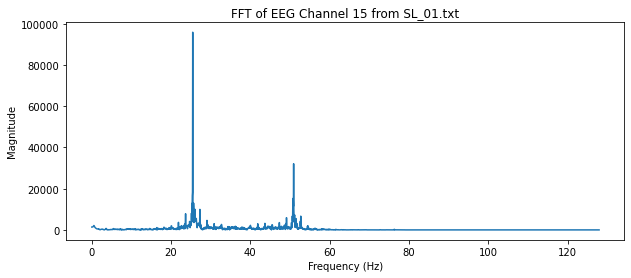

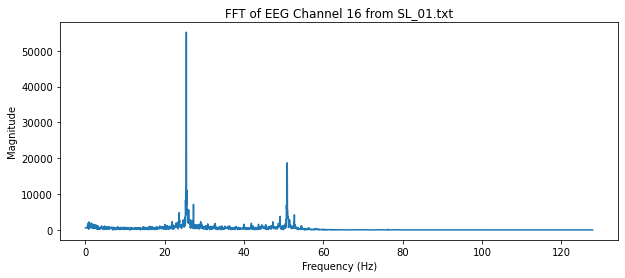

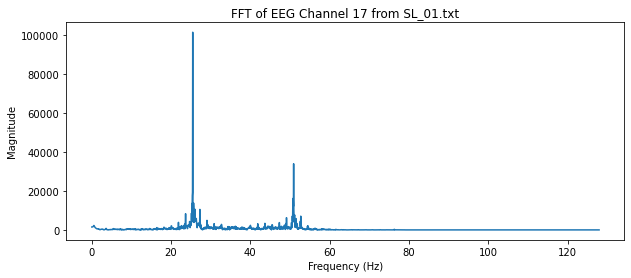

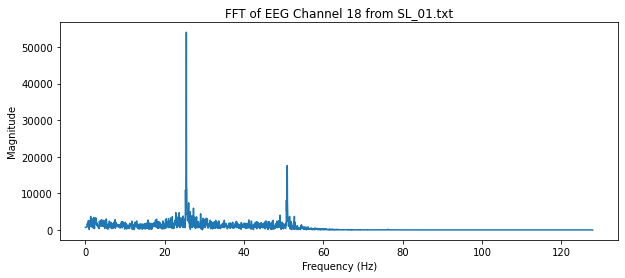

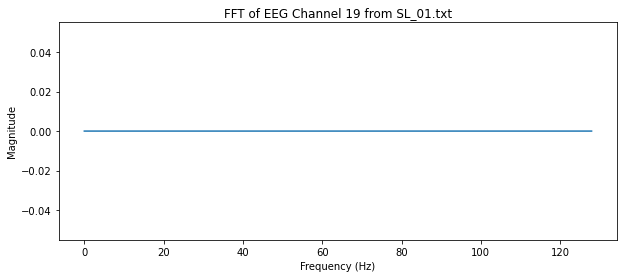

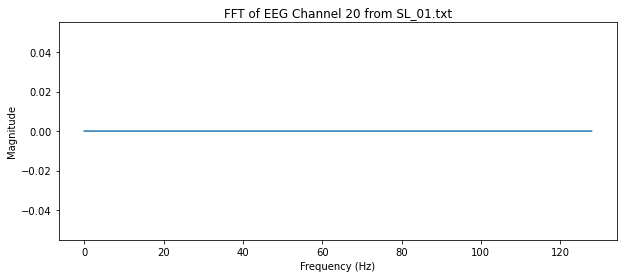

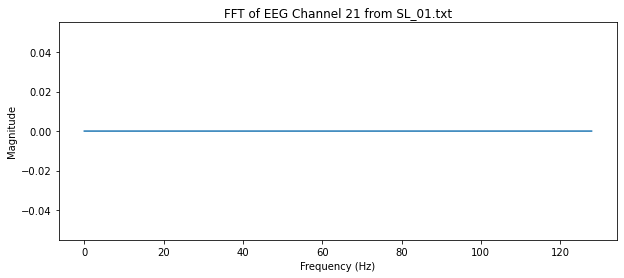

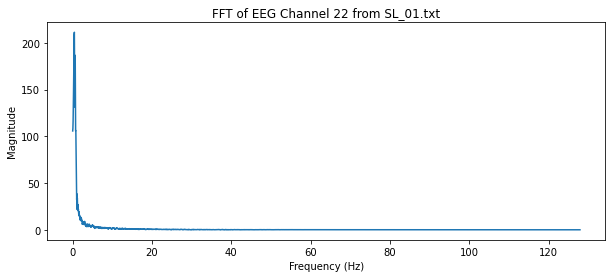

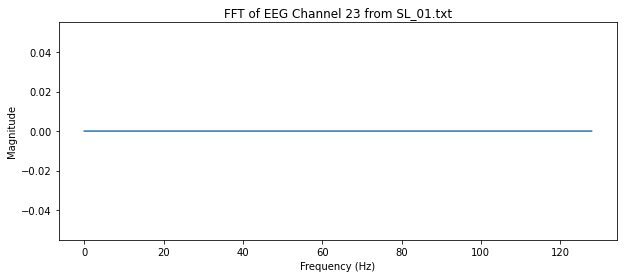

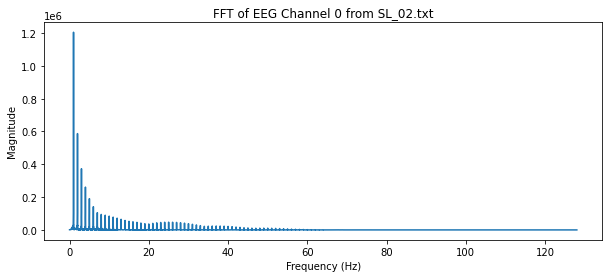

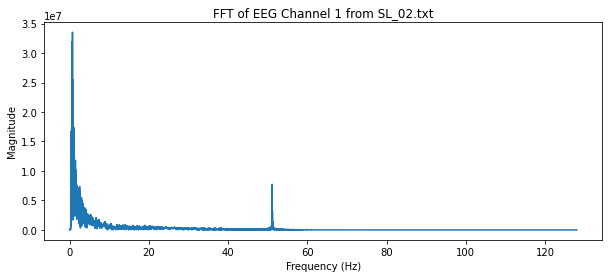

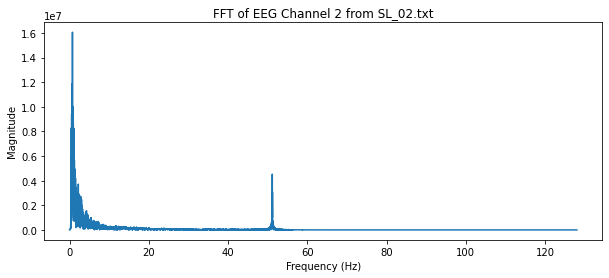

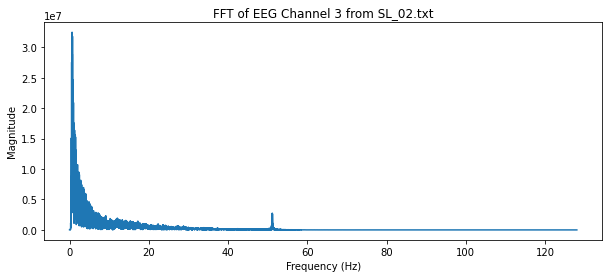

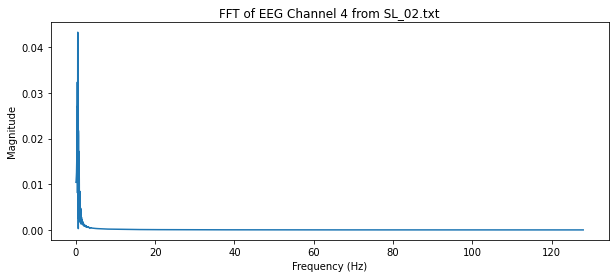

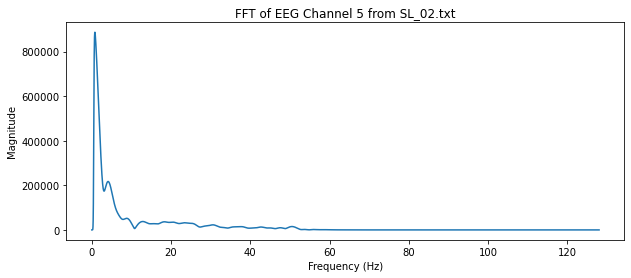

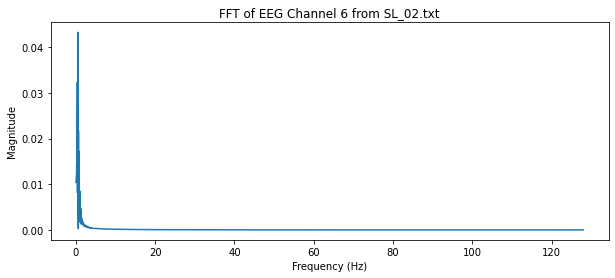

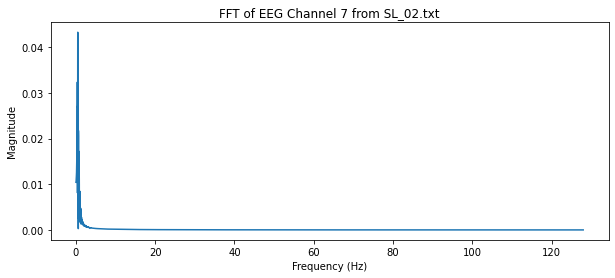

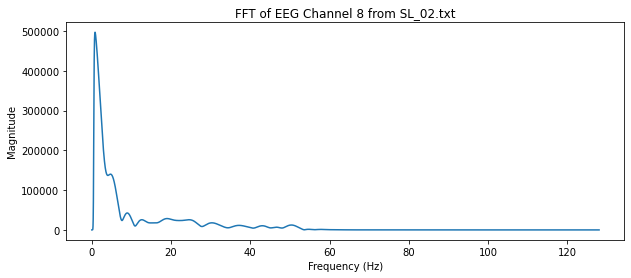

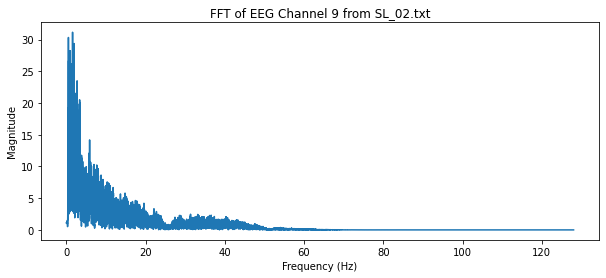

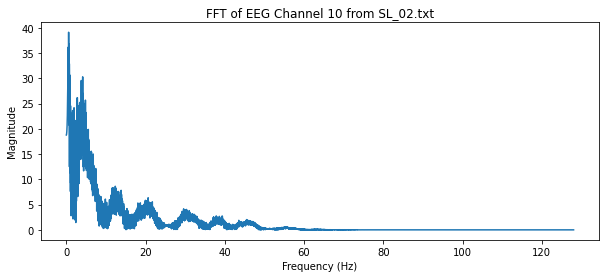

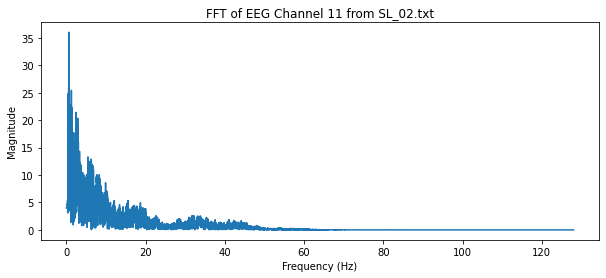

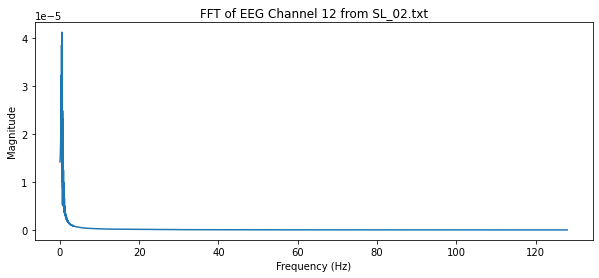

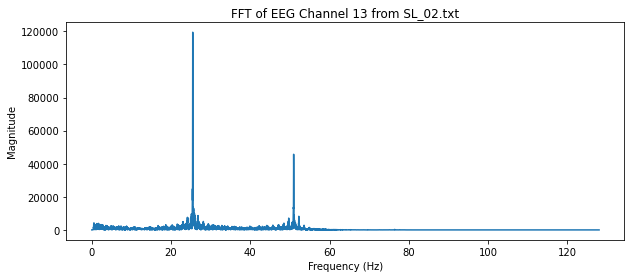

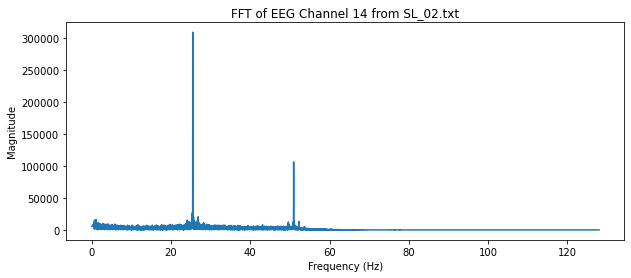

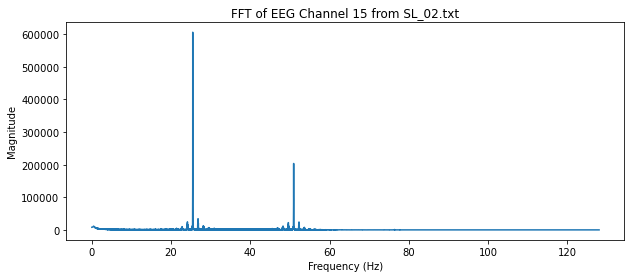

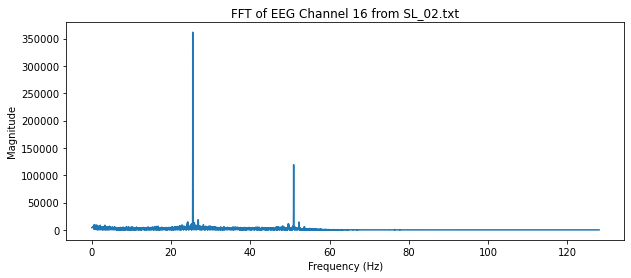

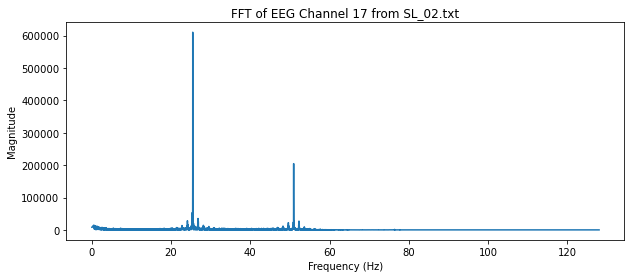

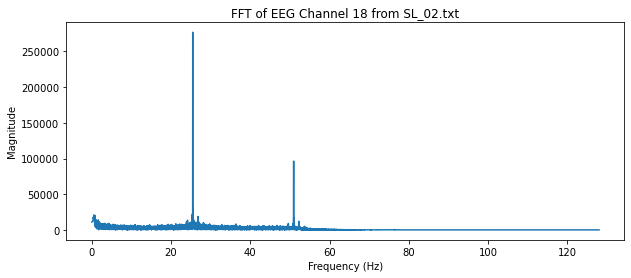

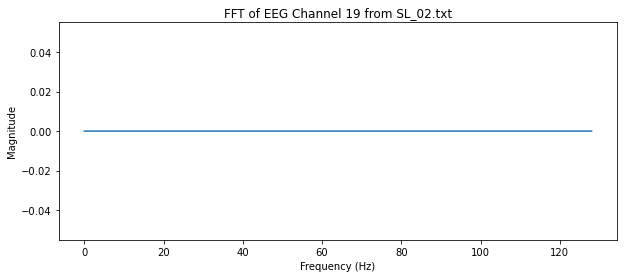

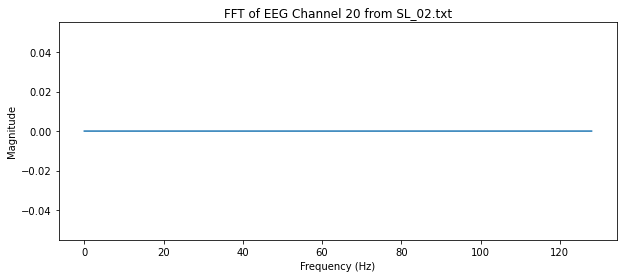

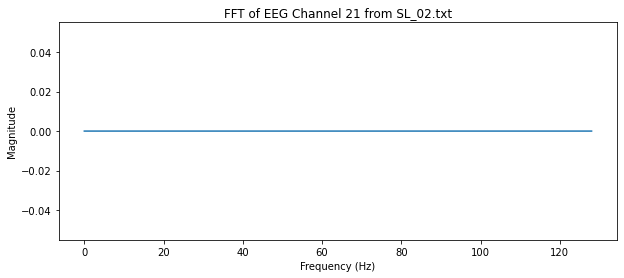

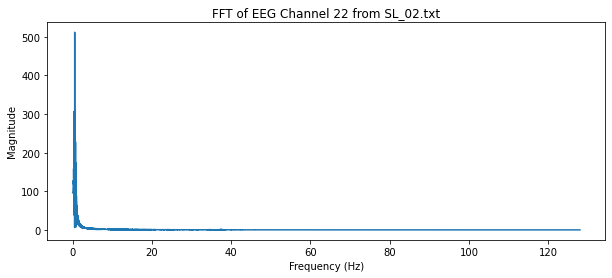

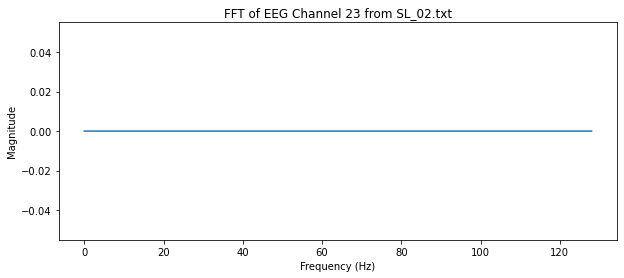

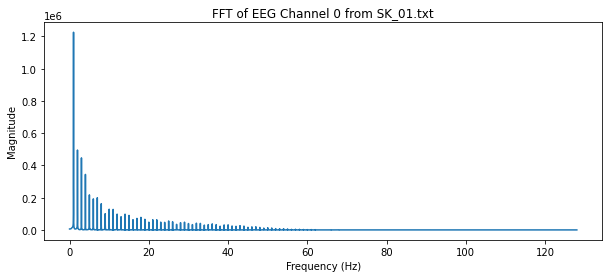

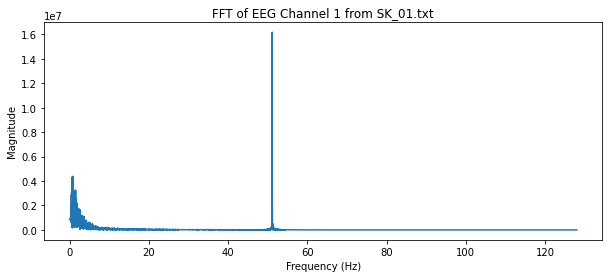

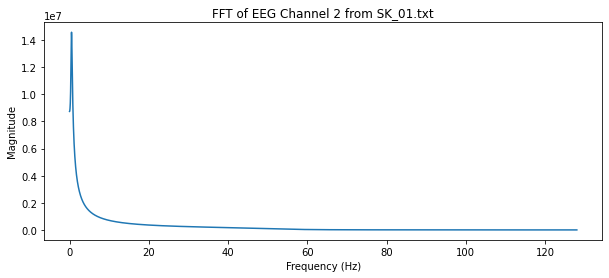

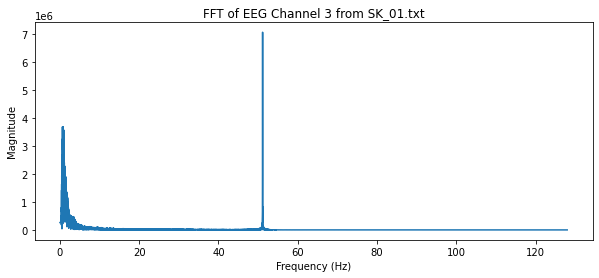

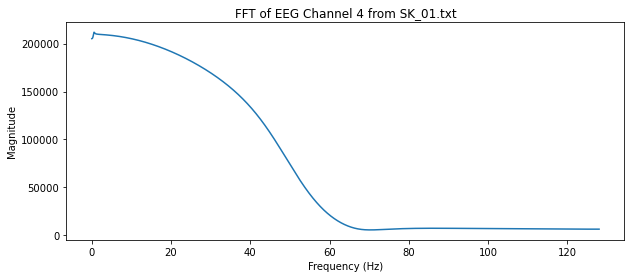

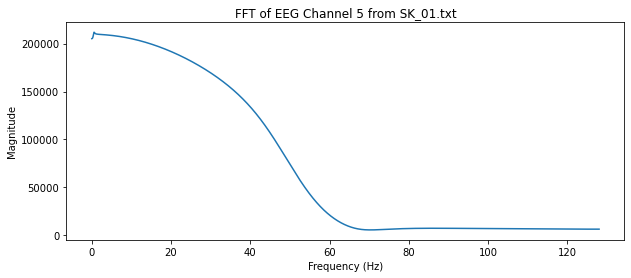

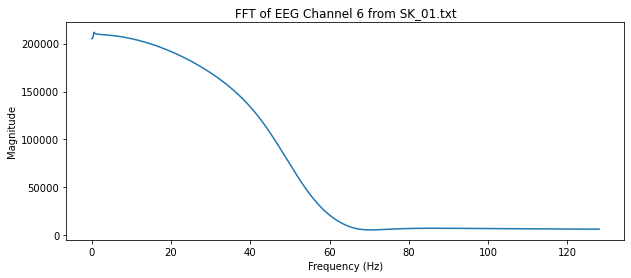

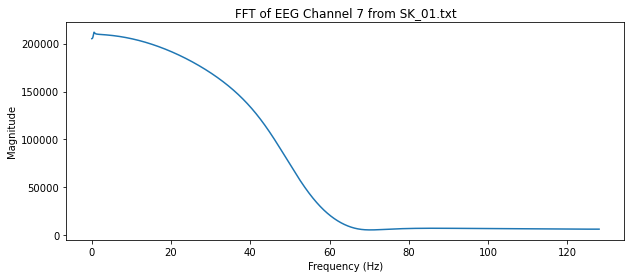

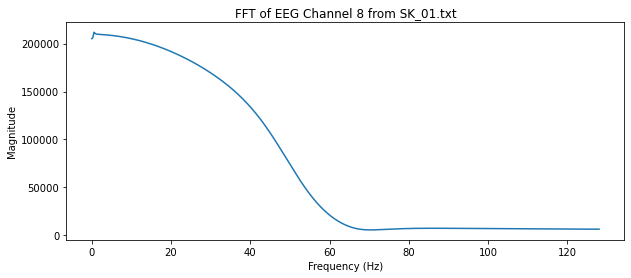

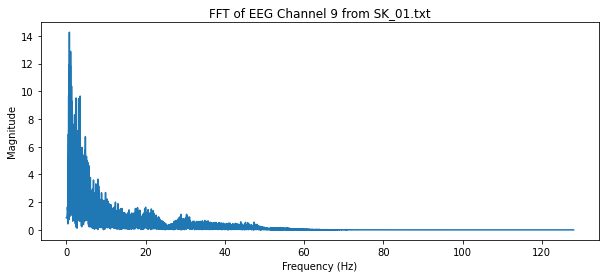

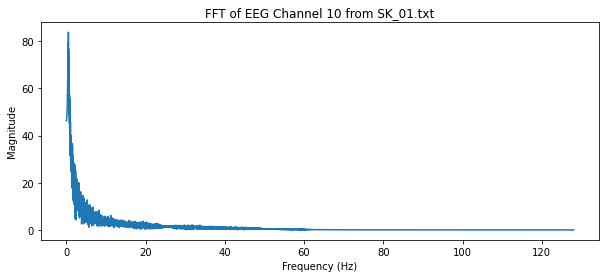

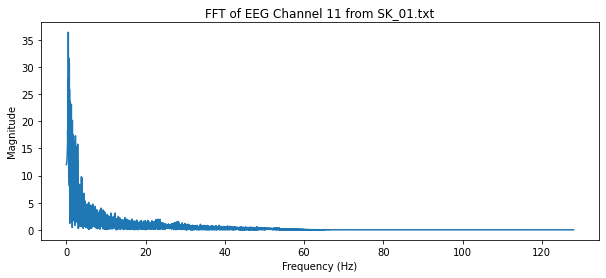

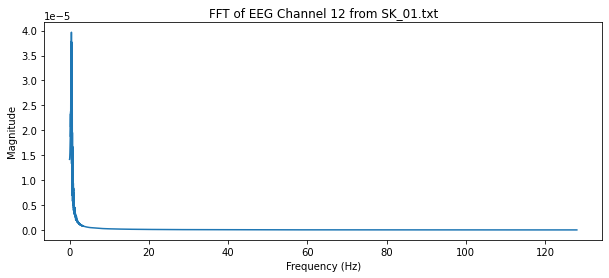

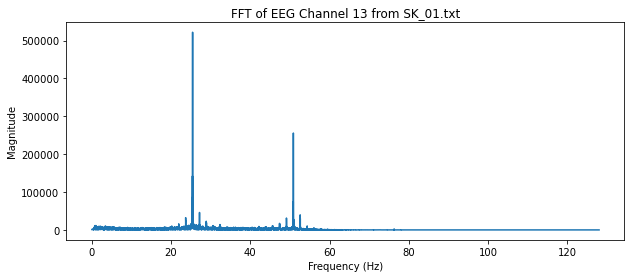

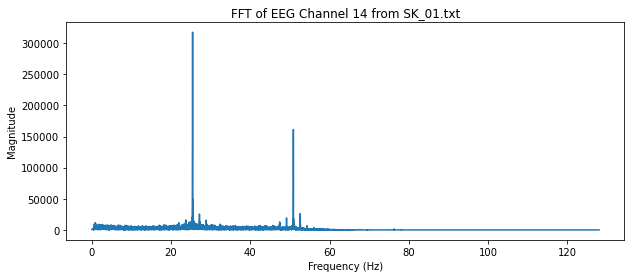

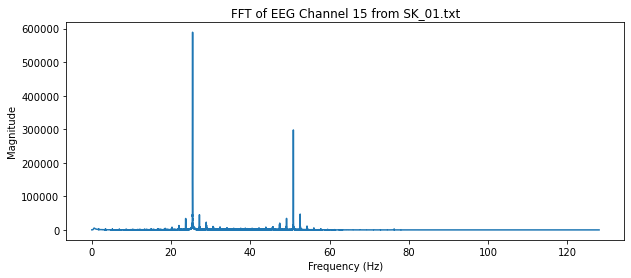

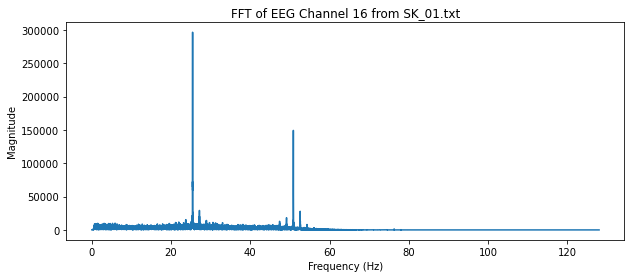

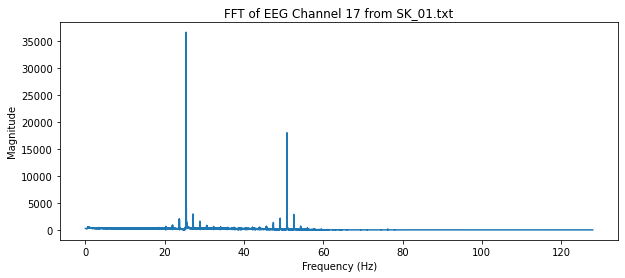

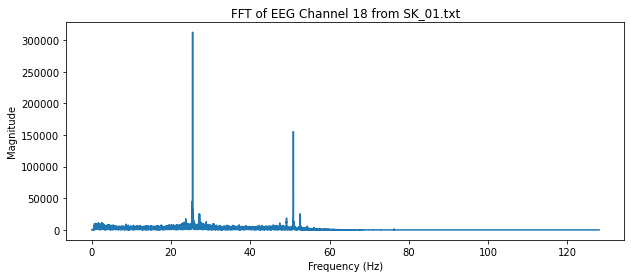

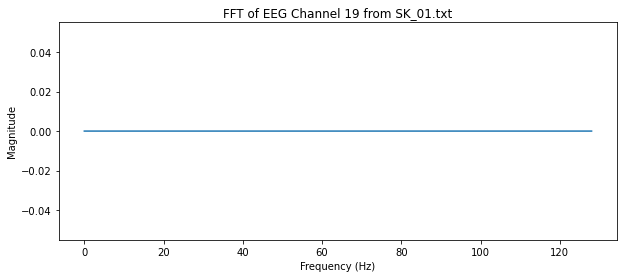

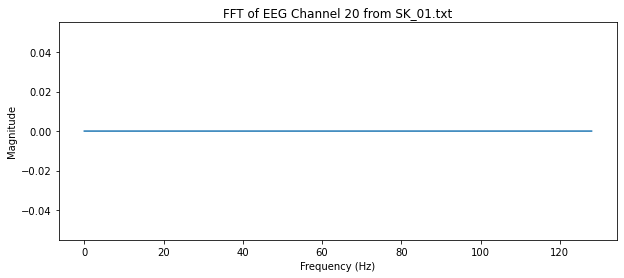

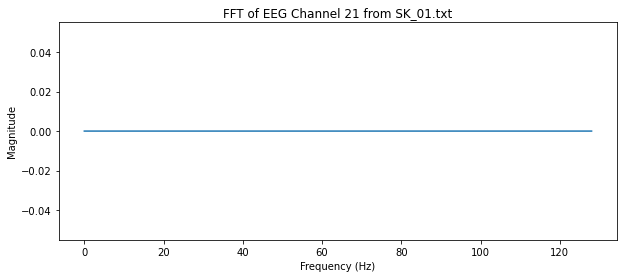

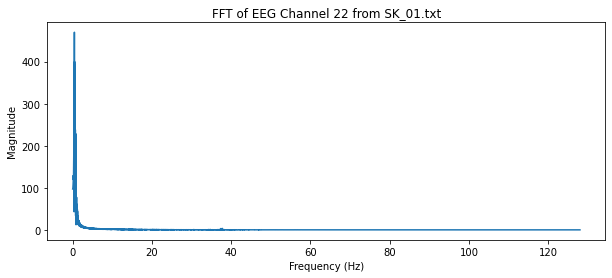

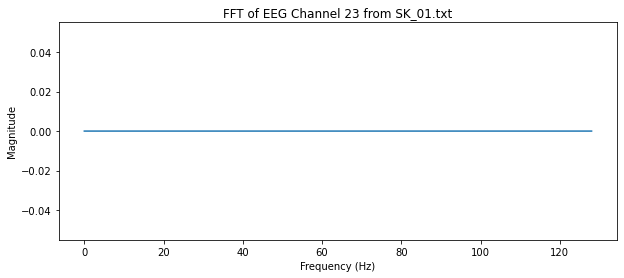

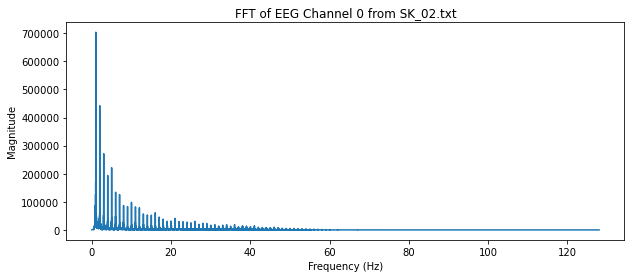

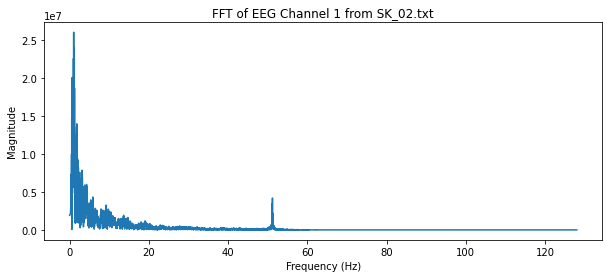

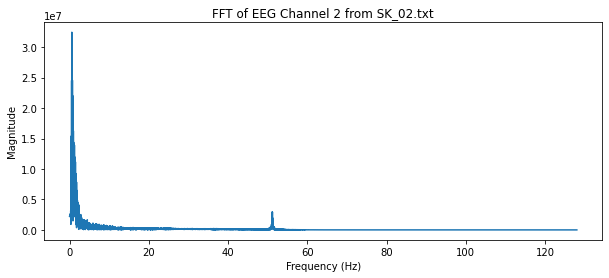

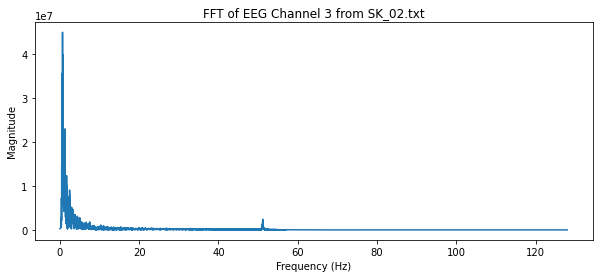

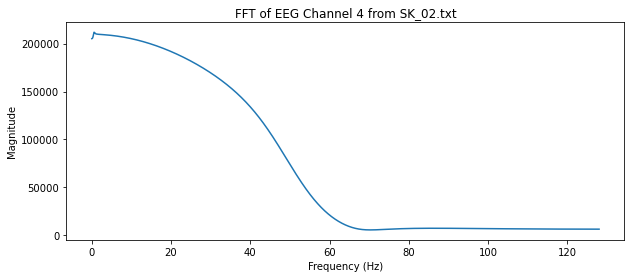

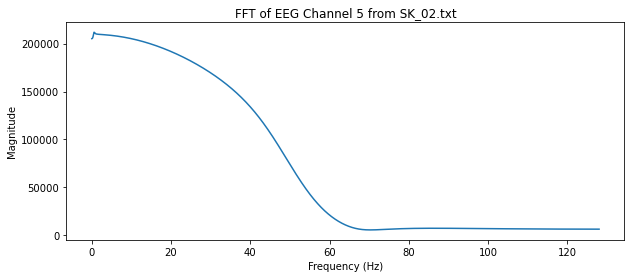

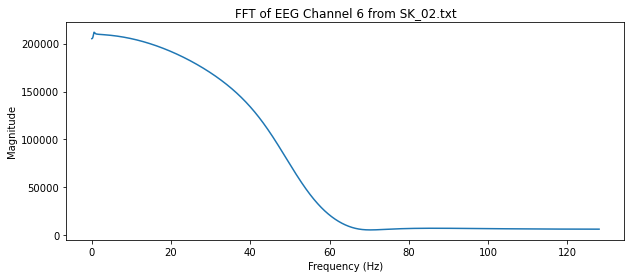

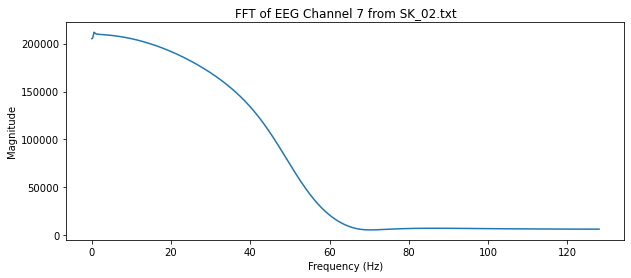

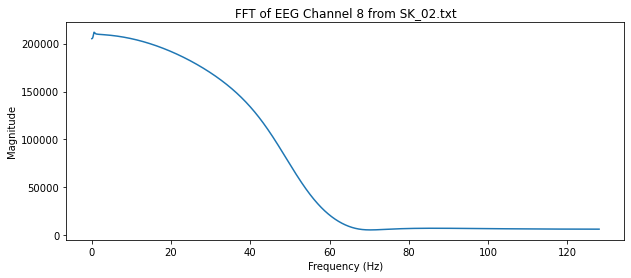

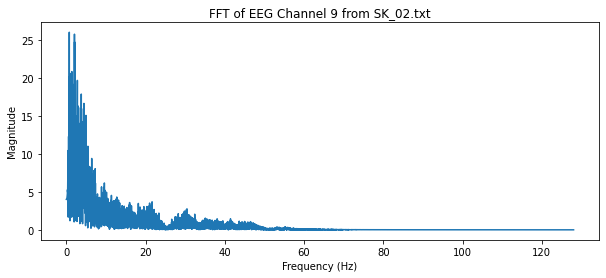

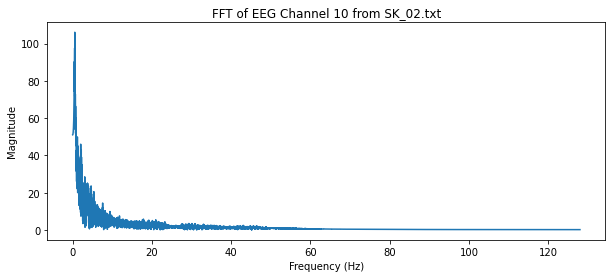

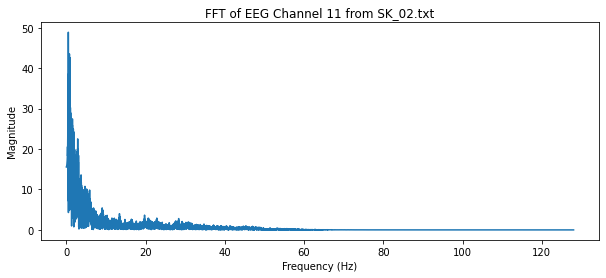

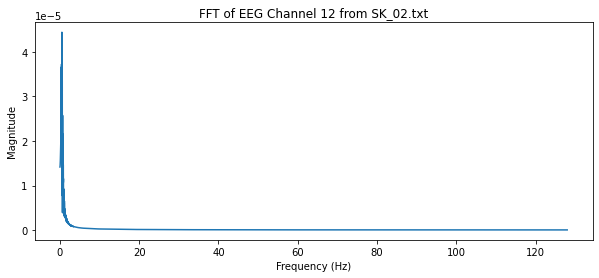

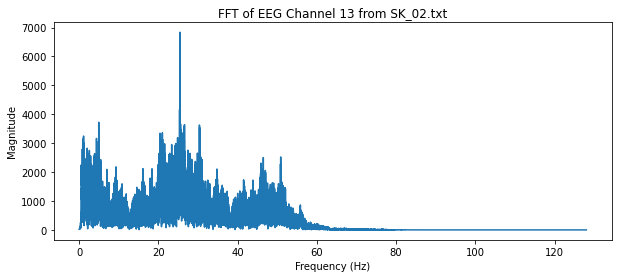

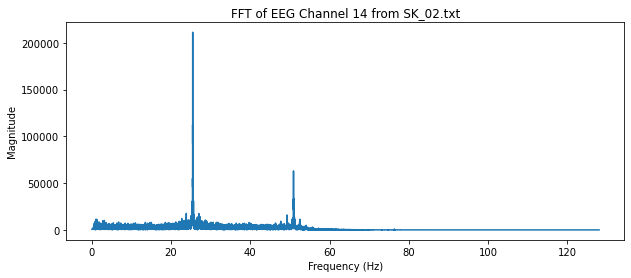

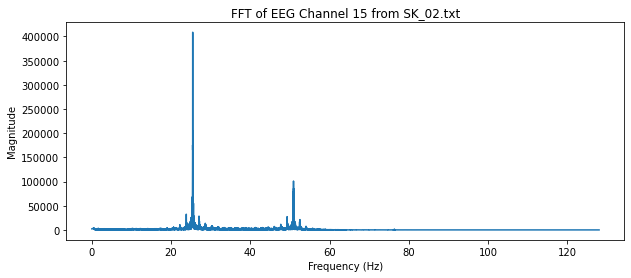

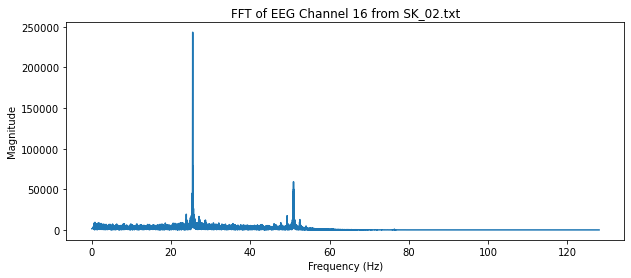

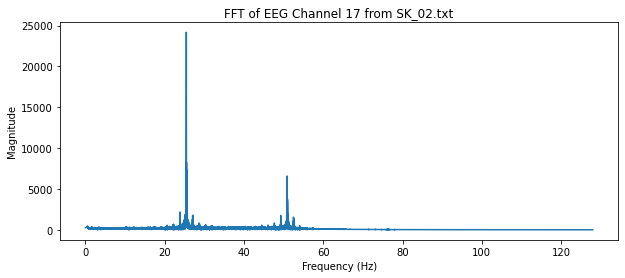

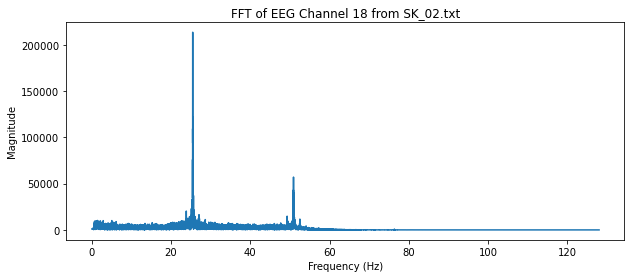

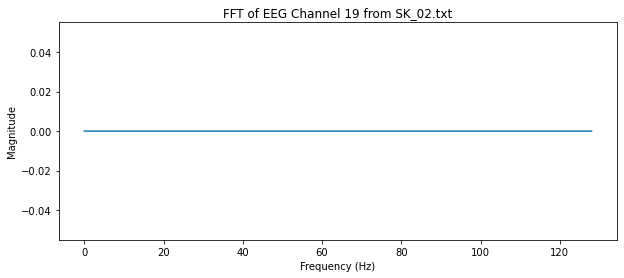

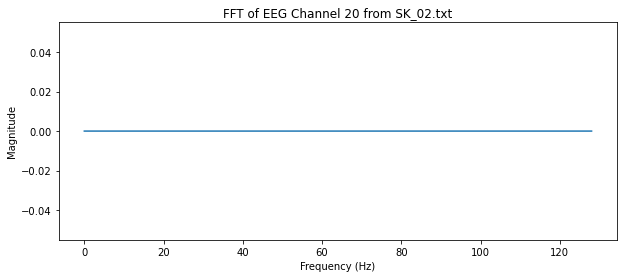

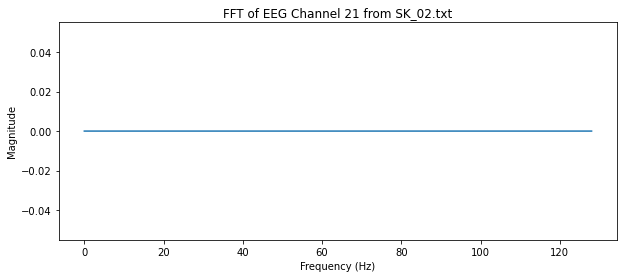

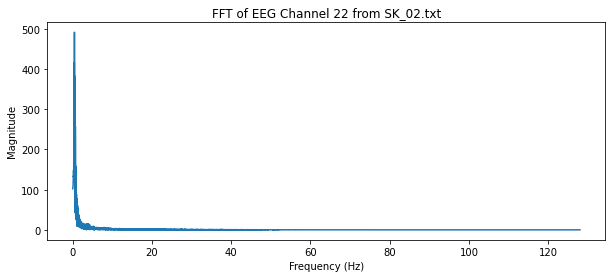

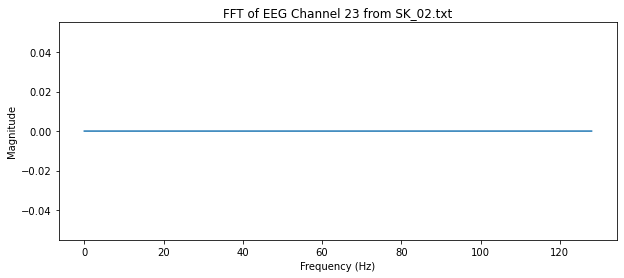

In [32]:
import matplotlib.pyplot as plt

# Compute FFT
def compute_fft(data, fs):
    n = len(data)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_values = np.fft.fft(data)
    fft_magnitude = np.abs(fft_values)
    return freqs[:n // 2], fft_magnitude[:n // 2]  # Return only positive frequencies

# Perform FFT for each file and plot
for i, data in enumerate(filtered_eeg_data):
    for channel in range(data.shape[1]):
        freqs, fft_magnitude = compute_fft(data[:, channel], sampling_rate)
        plt.figure(figsize=(10, 4))
        plt.plot(freqs, fft_magnitude)
        plt.title(f'FFT of EEG Channel {channel} from {file_names[i]}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()


In [33]:
# Define a function to calculate power in specific frequency bands
def bandpower(data, freqs, low, high):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(data[idx_band])

# Define the EEG bands
bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 50)}

# Extract power in each band for each file
features = []
labels = []

for file_name in file_names:
    # Load data
    data = load_clean_data(file_name)
    
    # Apply filtering
    filtered_data = apply_bandpass_filter(data, lowcut, highcut, sampling_rate)
    
    # Extract features
    feature_vector = []
    for channel in range(filtered_data.shape[1]):
        freqs, fft_magnitude = compute_fft(filtered_data[:, channel], sampling_rate)
        band_features = [bandpower(fft_magnitude, freqs, *bands[band_name]) for band_name in bands]
        feature_vector.extend(band_features)
    
    features.append(feature_vector)
    
    # Label: Assume HR files are class 0, SL files are class 1
    if 'HR' in file_name:
        labels.append(0)
    else:
        labels.append(1)

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Print updated shapes
print("Updated Features shape:", features.shape)
print("Updated Labels shape:", labels.shape)


Updated Features shape: (6, 120)
Updated Labels shape: (6,)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Train a neural network
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network accuracy: {accuracy_nn * 100:.2f}%")


Neural Network accuracy: 0.00%


In [36]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {accuracy_lr * 100:.2f}%")


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1